In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf


# ----------------------------------------------------------------------------
# ARTIFICIAL DATASET GENERATION (TEACHER-STUDENT MODEL)
# ----------------------------------------------------------------------------
# Define the random feature map (using erf as in the paper's right panel)
def feature_map(x, w, coeff=1.0):
    """Return erf(x @ w.T) optionally scaled by coeff."""
    return erf(x @ w.T) * coeff

def generate_data(num_samples, dim, teacher_weights, noise_std=0.1):
    """
    Generates data from a single-index teacher model: y = erf(<β_true, x>) + noise.
    
    Args:
        num_samples (int): Number of data points to generate.
        dim (int): Dimensionality of the input data x.
        teacher_weights (np.ndarray): The 'true' but hidden teacher vector β_true.
        noise_std (float): Standard deviation of the Gaussian noise.
        
    Returns:
        tuple: (X, y) - The generated covariates and labels.
    """
    X = np.random.randn(num_samples, dim)
    projections = X @ teacher_weights
    
    # Use erf as a simple non-linear function
    y_noiseless = erf(projections)
    
    noise = np.random.randn(num_samples) * noise_std
    y = y_noiseless + noise
    return X, y

# ----------------------------------------------------------------------------
# EMPIRICAL DIAGONALIZATION (ALGORITHM 1)
# ----------------------------------------------------------------------------
def empirical_diagonalization(u_est, y_est, P_weights):
    """
    Estimates the kernel operator spectrum (Σ) and target coefficients (β_*)
    from a large hold-out dataset.
    
    Args:
        u_est (np.ndarray): N x d matrix of covariates for estimation.
        y_est (np.ndarray): N-dimensional vector of labels for estimation.
        P_weights (np.ndarray): P x d matrix of random feature weights.
        
    Returns:
        tuple: (Sigma_hat, beta_hat) - Estimated eigenvalues and coefficients.
    """
    N, d = u_est.shape
    P = P_weights.shape[0]

    print(f"Building {N}x{N} empirical kernel matrix...")
    # This is the K(x, x') = E[φ(x,w)φ(x',w)] part, approximated by a sum over P weights
    # Eq. (169) in the paper
    phi_u = feature_map(u_est, P_weights) # Shape (N, P)
    K_est = (1 / P) * (phi_u @ phi_u.T)

    print("Performing eigendecomposition...")
    # Normalize the kernel matrix to estimate the operator's eigenvalues.
    K_norm = (1 / N) * K_est

    # Get eigenvalues and NORM=1 eigenvectors
    Sigma_hat, V_numpy = np.linalg.eigh(K_norm)
    
    # Sort in descending order
    idx = np.argsort(Sigma_hat)[::-1]
    Sigma_hat = Sigma_hat[idx]
    V_numpy = V_numpy[:, idx]
    
    # Scale eigenvectors to have norm sqrt(N) as per the paper's convention
    psi_hat_matrix = V_numpy * np.sqrt(N)
    
    # Estimate beta_* using Eq. (171)
    beta_hat = (1 / N) * psi_hat_matrix.T @ y_est
    
    print("Estimation of Σ and β_* complete.")
    return Sigma_hat, beta_hat

# ----------------------------------------------------------------------------
# DETERMINISTIC EQUIVALENT IMPLEMENTATION
# ----------------------------------------------------------------------------
def solve_self_consistent_equations(n, p, lambda_reg, Sigma_hat, tol=1e-8, max_iter=1000):
    """
    Solves the coupled self-consistent equations for ν1 and ν2 iteratively.
    This implements the numerical scheme from Appendix C.1 (Eqs. 167-168).

    Args:
        n (int): Number of samples.
        p (int): Number of random features.
        lambda_reg (float): Ridge regularization parameter.
        Sigma_hat (np.ndarray): Eigenvalues of the kernel operator.
        tol (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
        
    Returns:
        tuple: (nu1, nu2) - The converged solutions.
    """
    # Initial guess for nu2
    nu2 = 1.0
    
    for _ in range(max_iter):
        nu2_old = nu2
        
        # Equation (167): Update nu1 based on the current nu2
        sqrt_term = np.sqrt(max(0, (1 - n/p)**2 + 4 * lambda_reg / (p * nu2)))
        nu1 = (nu2 / 2) * (1 - n/p + sqrt_term)
        
        # Equation from rearranging (168): Update nu2 based on new nu1 and old nu2
        trace_term = np.sum(Sigma_hat / (Sigma_hat + nu2))
        nu2 = nu1 + (nu2/p) * trace_term
        
        if np.abs(nu2 - nu2_old) < tol:
            break
            
    # Final update for nu1 based on the converged nu2
    sqrt_term = np.sqrt(max(0, (1 - n/p)**2 + 4 * lambda_reg / (p * nu2)))
    nu1 = (nu2 / 2) * (1 - n/p + sqrt_term)
    
    return nu1, nu2

def calculate_theoretical_risk(n, p, lambda_reg, sigma_sq, Sigma_hat, beta_hat):
    """
    Calculates the theoretical excess risk using the deterministic equivalent.

    Args:
        n (int): Number of samples.
        p (int): Number of features.
        lambda_reg (float): Ridge regularization parameter.
        sigma_sq (float): Noise variance.
        Sigma_hat (np.ndarray): Eigenvalues of Σ.
        beta_hat (np.ndarray): Target coefficients β_*.

    Returns:
        float: The predicted excess risk R_n,p.
    """
    # 1. Solve for nu1 and nu2
    nu1, nu2 = solve_self_consistent_equations(n, p, lambda_reg, Sigma_hat)
    
    # 2. Calculate helper trace terms
    trace_term_1 = np.sum(Sigma_hat / (Sigma_hat + nu2)**2)
    trace_term_2 = np.sum(Sigma_hat**2 / (Sigma_hat + nu2)**2)
    
    # 3. Calculate Upsilon (Υ) and Chi (χ) - Eqs. (20) & (21)
    Upsilon = (p/n) * ((1 - nu1/nu2)**2 + (nu1/nu2)**2 * trace_term_2 / (p - trace_term_2))
    if p - trace_term_2 <= 0: # Avoid division by zero in edge cases
        return np.nan
    Chi = trace_term_1 / (p - trace_term_2)
    
    # 4. Calculate Bias (B_n,p) - Eq. (22)
    bias_term_1 = np.sum(beta_hat**2 / (Sigma_hat + nu2)**2)
    bias_term_2 = np.sum(beta_hat**2 * Sigma_hat / (Sigma_hat + nu2)**2)
    
    if 1 - Upsilon <= 0: # Avoid division by zero
        return np.nan
    
    bias = nu2**2 * (bias_term_1 + Chi * bias_term_2) / (1 - Upsilon)
    
    # 5. Calculate Variance (V_n,p) - Eq. (23)
    variance = sigma_sq * (Upsilon / (1 - Upsilon))
    
    # 6. Total Excess Risk (R_n,p) - Eq. (24)
    risk = bias + variance
    
    return risk

# ----------------------------------------------------------------------------
# ACTUAL RFRR SIMULATION FOR VERIFICATION
# ----------------------------------------------------------------------------
def run_simulation(n_train, p_features, lambda_reg, teacher_weights, dim, noise_std):
    # Generate fresh training, test data and weights for each simulation run
    X_train, y_train = generate_data(n_train, dim, teacher_weights, noise_std)
    X_test, y_test = generate_data(1000, dim, teacher_weights, 0) # Noiseless test data
    W = np.random.randn(p_features, dim) / np.sqrt(dim) # Random feature weights

    Z_train = feature_map(X_train, W, coeff=1/np.sqrt(p_features))
    Z_test = feature_map(X_test, W, coeff=1/np.sqrt(p_features))
    
    # Solve ridge regression (RFRR)
    I = np.eye(p_features)
    alpha = np.linalg.solve(Z_train.T @ Z_train + lambda_reg * I, Z_train.T @ y_train)
    
    # Predict and calculate excess risk
    y_pred = Z_test @ alpha
    excess_risk = np.mean((y_pred - y_test)**2)
    return excess_risk

Generating large dataset for empirical diagonalization...
Building 10000x10000 empirical kernel matrix...
Performing eigendecomposition...
Estimation of Σ and β_* complete.

Calculating theoretical curves...
Running simulations for verification (this may take a moment)...


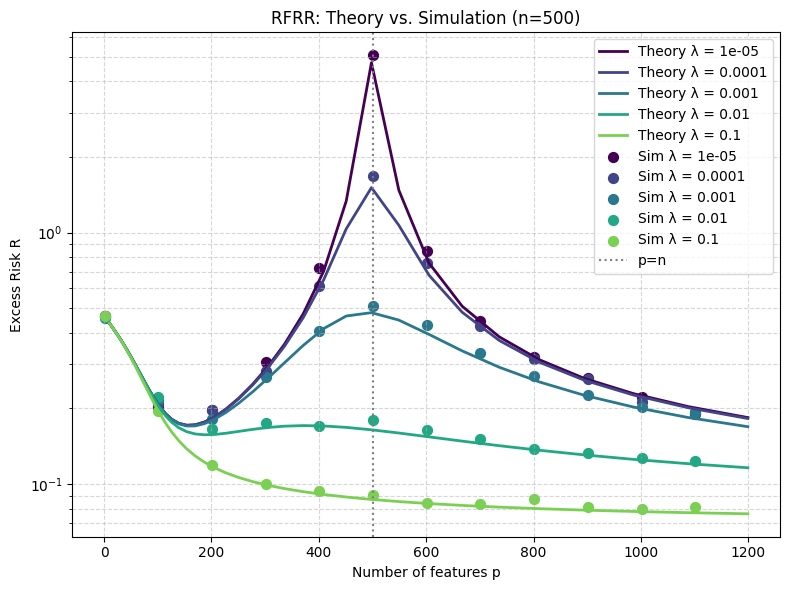

In [2]:
# ----------------------------------------------------------------------------
# MAIN SCRIPT
# ----------------------------------------------------------------------------

# --- Global Parameters ---
DIM = 100          # Input dimension of x
N_EST = 10000      # Number of samples for diagonalization (large N)
P_WEIGHTS = 10000  # Number of weights for kernel approximation (large P)
NOISE_STD = np.sqrt(0.1)
np.random.seed(42) # For reproducibility

# --- Generate the "true" teacher and the large dataset for estimation ---
teacher_vec = np.random.randn(DIM)
teacher_vec /= np.linalg.norm(teacher_vec) # Normalize teacher

print("Generating large dataset for empirical diagonalization...")
u_for_estimation, y_for_estimation = generate_data(N_EST, DIM, teacher_vec, 0) # Noiseless data for beta_* estimation
weights_for_estimation = np.random.randn(P_WEIGHTS, DIM) / np.sqrt(DIM)

# --- Perform Empirical Diagonalization to get Σ and β_* ---
Sigma_hat, beta_hat = empirical_diagonalization(u_for_estimation, y_for_estimation, weights_for_estimation)

# --- Parameters for the plot ---
n_samples = 500
lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
p_values = np.logspace(np.log10(10), np.log10(1200), 50, dtype=int)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(lambda_values)))

# --- Plot Theoretical Curves ---
print("\nCalculating theoretical curves...")
for i, lambda_reg in enumerate(lambda_values):
    risks = [calculate_theoretical_risk(n_samples, p, lambda_reg, NOISE_STD**2, Sigma_hat, beta_hat) for p in p_values]
    ax.plot(p_values, risks, label=f'Theory λ = {lambda_reg}', color=colors[i], lw=2)

# --- Plot Simulation Points for Verification ---
print("Running simulations for verification (this may take a moment)...")
p_sim_points = np.arange(1, 1201, 100)
num_seeds = 10 # Average over a few runs to reduce variance
for i, lambda_reg in enumerate(lambda_values):
    sim_risks = []
    for p in p_sim_points:
        risk_seeds = [run_simulation(n_samples, p, lambda_reg, teacher_vec, DIM, NOISE_STD) for _ in range(num_seeds)]
        sim_risks.append(np.mean(risk_seeds))
    ax.scatter(p_sim_points, sim_risks, color=colors[i], marker='o', s=50, label=f'Sim λ = {lambda_reg}')

# --- Final Plot Formatting ---
ax.set_yscale('log')
ax.set_xlabel('Number of features p')
ax.set_ylabel('Excess Risk R')
ax.set_title(f'RFRR: Theory vs. Simulation (n={n_samples})')
ax.axvline(x=n_samples, color='gray', linestyle=':', label=f'p=n')
ax.legend()
ax.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# It took 3m 21s to run on an M1 MacBook Pro